In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

# # Imports for Pycox

# # For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

# import pycox as pc
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

## Initial Cox Regression

In [5]:
interval_and_weather_merged = pd.read_csv('./interval_and_weather_merged.csv')
interval_and_weather_merged_reyna = pd.read_csv('./reyna_interval_and_weather_merge.csv')
df_list = [interval_and_weather_merged, interval_and_weather_merged_reyna ]
print(interval_and_weather_merged.shape)
print(interval_and_weather_merged_reyna.shape)
interval_and_weather_merged = pd.concat(df_list)

interval_and_weather_merged

(298, 21)
(46, 21)


,Unnamed: 0,endtime,starttime,interval,departing_insect,arriving_insect,sheet_title,timestamp_pd,timestamp_pd_rounded,same_insect,...,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,0,0 days 11:41:43,0 days 11:44:13,150000000000,Insecta,Insecta,07-28-2022 i10 Zinnia,2022-07-28 11:41:43,2022-07-28 12:00:00,1,...,23.0,100.0,0.0,NaN,270.0,7.2,NaN,1014.0,NaN,3.0
1,1,0 days 11:44:43,0 days 12:04:13,1170000000000,Insecta,Syrphinae,07-28-2022 i10 Zinnia,2022-07-28 11:44:43,2022-07-28 12:00:00,0,...,23.0,100.0,0.0,NaN,270.0,7.2,NaN,1014.0,NaN,3.0
2,2,0 days 13:43:07,0 days 13:54:07,660000000000,Halictus ligatus/poeyi,Syrphidae,07-28-2022 i4 Black-eyed Susan,2022-07-28 13:43:07,2022-07-28 14:00:00,0,...,25.0,79.0,0.0,NaN,271.0,8.3,NaN,1013.0,NaN,3.0
3,3,0 days 12:57:16,0 days 12:59:20,124000000000,Augochlorini,Apis mellifera,08-04-2022 i8 Cup Plant,2022-08-04 12:57:16,2022-08-04 13:00:00,1,...,25.0,84.0,0.0,NaN,220.0,7.0,NaN,1019.0,NaN,1.0
4,4,0 days 13:00:22,0 days 13:00:53,31000000000,Apis mellifera,Augochlorini,08-04-2022 i8 Cup Plant,2022-08-04 13:00:22,2022-08-04 13:00:00,1,...,25.0,84.0,0.0,NaN,220.0,7.0,NaN,1019.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,43,0 days 12:17:54,0 days 13:09:55,3121000000000,Bombus impatiens,NaN,Great Blue Lobelia 08-25-2022 picture bag anal...,2022-08-25 12:17:54,2022-08-25 12:00:00,0,...,17.0,100.0,0.0,NaN,0.0,0.0,NaN,1019.0,NaN,1.0
42,41,0 days 12:38:26,0 days 12:39:56,90000000000,apoidea,Poanes zabulon,Great Blue Lobelia 08-25-2022 unbagged,2022-08-25 12:38:26,2022-08-25 13:00:00,0,...,21.0,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0
43,42,0 days 12:40:56,0 days 13:54:27,4411000000000,Poanes zabulon,Macroglossum stellatarum,Great Blue Lobelia 08-25-2022 unbagged,2022-08-25 12:40:56,2022-08-25 13:00:00,0,...,21.0,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0
44,44,0 days 13:10:55,0 days 13:20:55,600000000000,NaN,NaN,Great Blue Lobelia 08-25-2022 picture bag anal...,2022-08-25 13:10:55,2022-08-25 13:00:00,1,...,21.0,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0


In [6]:
# Data Cleanup including Removing American Aster
interval_and_weather_merged = interval_and_weather_merged[(interval_and_weather_merged['sheet_title'] != '10-14-2022 i11 American Aster') & (interval_and_weather_merged['sheet_title'] != '10-14-2022 i8 American Aster')]

# Interval column is in nanoseconds
interval_cut_off = 1*60*1000*1000000
df_less_than_interval = interval_and_weather_merged[(interval_and_weather_merged['interval'] < interval_cut_off) & (interval_and_weather_merged['same_insect'] == True)]

df_minus_short_interval_same_insect = interval_and_weather_merged[(interval_and_weather_merged['interval'] >= interval_cut_off) | (interval_and_weather_merged['same_insect'] == False)]
df_minus_short_interval_same_insect

,Unnamed: 0,endtime,starttime,interval,departing_insect,arriving_insect,sheet_title,timestamp_pd,timestamp_pd_rounded,same_insect,...,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,0,0 days 11:41:43,0 days 11:44:13,150000000000,Insecta,Insecta,07-28-2022 i10 Zinnia,2022-07-28 11:41:43,2022-07-28 12:00:00,1,...,23.0,100.0,0.0,NaN,270.0,7.2,NaN,1014.0,NaN,3.0
1,1,0 days 11:44:43,0 days 12:04:13,1170000000000,Insecta,Syrphinae,07-28-2022 i10 Zinnia,2022-07-28 11:44:43,2022-07-28 12:00:00,0,...,23.0,100.0,0.0,NaN,270.0,7.2,NaN,1014.0,NaN,3.0
2,2,0 days 13:43:07,0 days 13:54:07,660000000000,Halictus ligatus/poeyi,Syrphidae,07-28-2022 i4 Black-eyed Susan,2022-07-28 13:43:07,2022-07-28 14:00:00,0,...,25.0,79.0,0.0,NaN,271.0,8.3,NaN,1013.0,NaN,3.0
3,3,0 days 12:57:16,0 days 12:59:20,124000000000,Augochlorini,Apis mellifera,08-04-2022 i8 Cup Plant,2022-08-04 12:57:16,2022-08-04 13:00:00,1,...,25.0,84.0,0.0,NaN,220.0,7.0,NaN,1019.0,NaN,1.0
5,5,0 days 13:01:55,0 days 13:03:28,93000000000,Augochlorini,Augochlorini,08-04-2022 i8 Cup Plant,2022-08-04 13:01:55,2022-08-04 13:00:00,1,...,25.0,84.0,0.0,NaN,220.0,7.0,NaN,1019.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,43,0 days 12:17:54,0 days 13:09:55,3121000000000,Bombus impatiens,NaN,Great Blue Lobelia 08-25-2022 picture bag anal...,2022-08-25 12:17:54,2022-08-25 12:00:00,0,...,17.0,100.0,0.0,NaN,0.0,0.0,NaN,1019.0,NaN,1.0
42,41,0 days 12:38:26,0 days 12:39:56,90000000000,apoidea,Poanes zabulon,Great Blue Lobelia 08-25-2022 unbagged,2022-08-25 12:38:26,2022-08-25 13:00:00,0,...,21.0,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0
43,42,0 days 12:40:56,0 days 13:54:27,4411000000000,Poanes zabulon,Macroglossum stellatarum,Great Blue Lobelia 08-25-2022 unbagged,2022-08-25 12:40:56,2022-08-25 13:00:00,0,...,21.0,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0
44,44,0 days 13:10:55,0 days 13:20:55,600000000000,NaN,NaN,Great Blue Lobelia 08-25-2022 picture bag anal...,2022-08-25 13:10:55,2022-08-25 13:00:00,1,...,21.0,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0


In [68]:
def run_cox_regression_on_all_data(interval_and_weather_merged):
  # JCB: List of ones to represent that all intervals have completed
  status = np.ones(interval_and_weather_merged.shape[0])

  mod = smf.phreg("interval ~ same_insect + temp + wspd + dwpt + coco",
                  interval_and_weather_merged, status=status, ties="efron")
  rslt = mod.fit()
  print(rslt.summary())
  
run_cox_regression_on_all_data(interval_and_weather_merged)

status = np.ones(interval_and_weather_merged.shape[0])
interval_and_weather_merged['status'] = status
# 

                         Results: PHReg
Model:                      PH Reg         Sample size:       292
Dependent variable:         interval       Num. events:       292
Ties:                       Efron                                
-----------------------------------------------------------------
             log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------
same_insect  0.3329    0.1303 1.3950  2.5560 0.0106 1.0807 1.8008
temp         0.0472    0.0258 1.0483  1.8301 0.0672 0.9967 1.1027
wspd         0.0157    0.0145 1.0158  1.0855 0.2777 0.9874 1.0450
dwpt        -0.0950    0.0196 0.9093 -4.8518 0.0000 0.8751 0.9449
coco         0.3239    0.0577 1.3825  5.6186 0.0000 1.2348 1.5479
Confidence intervals are for the hazard ratios


/var/folders/vt/546593w53sx4zw12xsp5qhx00000gp/T/ipykernel_52508/1563135374.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_and_weather_merged['status'] = status


In [100]:
rossi = load_rossi()

# same_insect + temp + wspd + dwpt + coco
cph = CoxPHFitter()

trimmed_df = interval_and_weather_merged[['interval','status', 'same_insect' , 'temp' , 'wspd' , 'dwpt' , 'coco']].copy()
trimmed_df = trimmed_df.reset_index(drop=True)
cph.fit(trimmed_df, 'interval', 'status')
# cph.print_summary(model="untransformed variables", decimals=3)
cph.check_assumptions(trimmed_df, p_value_threshold=0.05, show_plots=True)
# trimmed_df


Proportional hazard assumption looks okay.


[]

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.45 <0.005     10.45
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.15
mar  km              0.60   0.44      1.19
     rank            0.71   0.40      1.32
paro km              0.12   0.73      0.45
     rank            0.13   0.71      0.49
prio km              0.02   0.88      0.18
     rank            0.02   0.89      0.17
race km              1.44   0.23      2.12
     rank            1.43   0.23      2.11
wexp km              7.48   0.01      7.32
     rank            7.31   0.01      7.19



1. Variable 'age' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/l

[[<Axes: xlabel='rank-transformed time\n(p=0.0007)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0009)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0068)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0063)'>]]

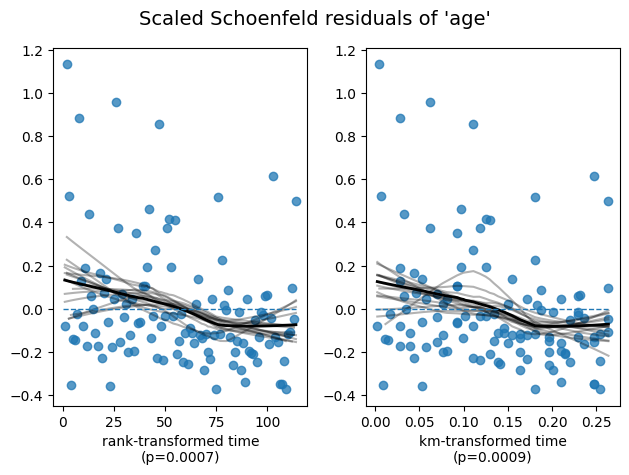

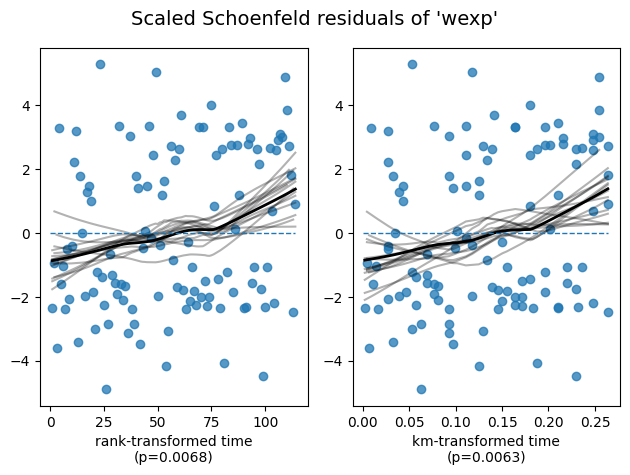

In [101]:
cph.fit(rossi, 'week', 'arrest')
cph.check_assumptions(rossi, p_value_threshold=0.05, show_plots=True)
# rossi

## Notes from Tom
Qualitative 

In [61]:
def run_bin_temp_analysis(df, binned_column, number_of_bins):
    # Find the range of the `temp` column
    temp_min = df[binned_column].min()
    temp_max = df[binned_column].max()

    print(f"Photo data {binned_column} range")
    print(temp_min)
    print(temp_max)

    # Calculate the range of each group based on the total range of `temp`
    group_range = (temp_max - temp_min) / 3
    print(group_range)
    # Create a new column in the DataFrame to hold the temperature group for each row
    df['binned_group'] = pd.cut(df[binned_column], bins=[temp_min, temp_min+group_range, temp_min+2*group_range, temp_max], labels=['Low', 'Medium', 'High'])

    # Print out the DataFrame grouped by temperature group
    for name, group in interval_and_weather_merged.groupby('binned_group'):
        print(f"Group: {name}\n")
        print(f"Number of rows in group: {len(group)}\n")
        group_temp_range = f"{name}: {group['temp'].min()} - {group['temp'].max()}"
        print('group_temp_range', group_temp_range)

        status = np.ones(len(group))

        mod = smf.phreg("interval ~ same_insect + temp + wspd + dwpt + coco",
                        group, status=status, ties="efron")
        rslt = mod.fit()
        print(rslt.summary())
# df_minus_short_interval_same_insect

run_bin_temp_analysis(interval_and_weather_merged, 'temp', 3)

Photo data temp range
12.0
31.0
6.333333333333333
Group: Low

Number of rows in group: 80

group_temp_range Low: 14.0 - 18.0
                         Results: PHReg
Model:                     PH Reg          Sample size:        80
Dependent variable:        interval        Num. events:        80
Ties:                      Efron                                 
-----------------------------------------------------------------
             log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------
same_insect -0.0800    0.3653 0.9231 -0.2191 0.8266 0.4512 1.8886
temp        -0.0498    0.1089 0.9514 -0.4578 0.6471 0.7686 1.1777
wspd         0.0155    0.0237 1.0156  0.6537 0.5133 0.9695 1.0638
dwpt        -0.1907    0.0548 0.8264 -3.4775 0.0005 0.7422 0.9202
coco         0.4602    0.1262 1.5844  3.6480 0.0003 1.2373 2.0289
Confidence intervals are for the hazard ratios
Group: Medium

Number of rows in group: 156

group_temp_range 

/var/folders/vt/546593w53sx4zw12xsp5qhx00000gp/T/ipykernel_52508/3627730001.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binned_group'] = pd.cut(df[binned_column], bins=[temp_min, temp_min+group_range, temp_min+2*group_range, temp_max], labels=['Low', 'Medium', 'High'])


                         Results: PHReg
Model:                      PH Reg         Sample size:       156
Dependent variable:         interval       Num. events:       156
Ties:                       Efron                                
-----------------------------------------------------------------
             log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------
same_insect  0.3998    0.1732 1.4915  2.3081 0.0210 1.0622 2.0945
temp         0.0434    0.0786 1.0443  0.5514 0.5813 0.8951 1.2184
wspd         0.0116    0.0234 1.0116  0.4940 0.6213 0.9663 1.0591
dwpt        -0.0988    0.0255 0.9060 -3.8793 0.0001 0.8619 0.9523
coco         0.3124    0.0902 1.3667  3.4645 0.0005 1.1453 1.6308
Confidence intervals are for the hazard ratios
Group: High

Number of rows in group: 50

group_temp_range High: 25.0 - 31.0
                         Results: PHReg
Model:                     PH Reg          Sample size:        50
Depe

In [59]:
# Summary Stats about Reyna's Data
print(interval_and_weather_merged_reyna.temp.quantile([0.25,0.5,0.75]))

print(interval_and_weather_merged.temp.quantile([0.25,0.5,0.75]))

0.25    21.00
0.50    23.00
0.75    27.75
Name: temp, dtype: float64
0.25    16.75
0.50    22.00
0.75    23.00
Name: temp, dtype: float64


### New binning analysis function but for time

In [52]:
def run_bin_time_analysis(interval_and_weather_merged, binned_column, number_of_bins):

    interval_and_weather_merged[binned_column] = pd.to_datetime(interval_and_weather_merged[binned_column])

    # Find the range of the `time` column
    time_min = interval_and_weather_merged[binned_column].min().floor('H')
    time_max = interval_and_weather_merged[binned_column].max().floor('H')

    print(f"Photo data {binned_column} range")
    print(time_min)
    print(time_max)

    # Calculate the range of each group based on the total range of `time`
    group_range = (time_max - time_min) / 3
    print(group_range)
    # Create a new column in the DataFrame to hold the time group for each row
    interval_and_weather_merged['binned_group'] = pd.cut(interval_and_weather_merged[binned_column], bins=[time_min, time_min+group_range, time_min+2*group_range, time_max], labels=['Low', 'Medium', 'High'])

    # Print out the DataFrame grouped by time group
    for name, group in interval_and_weather_merged.groupby('time_group'):
        print(f"Group: {name}\n")
        print(f"Number of rows in group: {len(group)}\n")
        status = np.ones(len(group))

        mod = smf.phreg("interval ~ same_insect + temp + wspd + dwpt + coco",
                        group, status=status, ties="efron")
        rslt = mod.fit()
        print(rslt.summary())
# df_minus_short_interval_same_insect

run_bin_time_analysis(df_minus_short_interval_same_insect, 'timestamp_pd_rounded', 3)

Photo data timestamp_pd_rounded range
2022-07-21 12:00:00
2022-10-14 15:00:00
28 days 09:00:00


/var/folders/vt/546593w53sx4zw12xsp5qhx00000gp/T/ipykernel_52508/738662177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_and_weather_merged[binned_column] = pd.to_datetime(interval_and_weather_merged[binned_column])
/var/folders/vt/546593w53sx4zw12xsp5qhx00000gp/T/ipykernel_52508/738662177.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_and_weather_merged['binned_group'] = pd.cut(interval_and_weather_merged[binned_column], bins=[time_min, time_min+group_range, time_min+2*group_r

KeyError: 'time_group'

## Pycox Expirementation


In [20]:
# Add status to the dataframe
interval_and_weather_merged = interval_and_weather_merged.assign(status=1)
interval_and_weather_merged.head()

,Unnamed: 0,endtime,starttime,interval,departing_insect,arriving_insect,sheet_title,timestamp_pd,timestamp_pd_rounded,same_insect,...,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,status
0,0,0 days 11:41:43,0 days 11:44:13,150000000000,Insecta,Insecta,07-28-2022 i10 Zinnia,2022-07-28 11:41:43,2022-07-28 12:00:00,1,...,100.0,0.0,NaN,270.0,7.2,NaN,1014.0,NaN,3.0,1
1,1,0 days 11:44:43,0 days 12:04:13,1170000000000,Insecta,Syrphinae,07-28-2022 i10 Zinnia,2022-07-28 11:44:43,2022-07-28 12:00:00,0,...,100.0,0.0,NaN,270.0,7.2,NaN,1014.0,NaN,3.0,1
2,2,0 days 13:43:07,0 days 13:54:07,660000000000,Halictus ligatus/poeyi,Syrphidae,07-28-2022 i4 Black-eyed Susan,2022-07-28 13:43:07,2022-07-28 14:00:00,0,...,79.0,0.0,NaN,271.0,8.3,NaN,1013.0,NaN,3.0,1
3,3,0 days 12:57:16,0 days 12:59:20,124000000000,Augochlorini,Apis mellifera,08-04-2022 i8 Cup Plant,2022-08-04 12:57:16,2022-08-04 13:00:00,1,...,84.0,0.0,NaN,220.0,7.0,NaN,1019.0,NaN,1.0,1
4,4,0 days 13:00:22,0 days 13:00:53,31000000000,Apis mellifera,Augochlorini,08-04-2022 i8 Cup Plant,2022-08-04 13:00:22,2022-08-04 13:00:00,1,...,84.0,0.0,NaN,220.0,7.0,NaN,1019.0,NaN,1.0,1


In [27]:
# Extract input features and output label
x = interval_and_weather_merged[['temp', 'dwpt', 'wspd', 'coco', 'same_insect']]
y = interval_and_weather_merged[['interval', 'status']]

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(y_train.head())

# TODO: Skipping the step with the DataFrameMapper function


# Transform output label
get_target = lambda df: (df['interval'].values, df['status'].values)
labtrans = LogisticHazard.label_transform(cuts=100)
y_train_trans = labtrans.fit_transform(*get_target(y_train))

# labtrans.cuts

          interval  status
262  2062000000000       1
281   141000000000       1
278   426000000000       1
73     76000000000       1
25     14000000000       1


array([0.00000000e+00, 1.27828283e+11, 2.55656566e+11, 3.83484848e+11,
       5.11313131e+11, 6.39141414e+11, 7.66969697e+11, 8.94797980e+11,
       1.02262626e+12, 1.15045455e+12, 1.27828283e+12, 1.40611111e+12,
       1.53393939e+12, 1.66176768e+12, 1.78959596e+12, 1.91742424e+12,
       2.04525253e+12, 2.17308081e+12, 2.30090909e+12, 2.42873737e+12,
       2.55656566e+12, 2.68439394e+12, 2.81222222e+12, 2.94005051e+12,
       3.06787879e+12, 3.19570707e+12, 3.32353535e+12, 3.45136364e+12,
       3.57919192e+12, 3.70702020e+12, 3.83484848e+12, 3.96267677e+12,
       4.09050505e+12, 4.21833333e+12, 4.34616162e+12, 4.47398990e+12,
       4.60181818e+12, 4.72964646e+12, 4.85747475e+12, 4.98530303e+12,
       5.11313131e+12, 5.24095960e+12, 5.36878788e+12, 5.49661616e+12,
       5.62444444e+12, 5.75227273e+12, 5.88010101e+12, 6.00792929e+12,
       6.13575758e+12, 6.26358586e+12, 6.39141414e+12, 6.51924242e+12,
       6.64707071e+12, 6.77489899e+12, 6.90272727e+12, 7.03055556e+12,
      

In [26]:

# Define model architecture
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

# Train model
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train.values, y_train_trans, batch_size, epochs, callbacks, val_data=(x_val.values, labtrans.transform(*get_target(y_val))))


RuntimeError: mat1 and mat2 must have the same dtype